# Cargue de Datos

In [61]:
import pandas as pd

#df = pd.read_csv("hf://datasets/USC-MOLA-Lab/MFRC/final_mfrc_data.csv")
df = pd.read_csv('data_split.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   translated_text    13080 non-null  object
 1   annotation_binary  13080 non-null  int64 
 2   data_split         13080 non-null  object
dtypes: int64(1), object(2)
memory usage: 306.7+ KB


In [62]:
df.data_split.value_counts()

data_split
train    9156
val      1962
test     1962
Name: count, dtype: int64

In [63]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

displacy.render(doc, style="ent")

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [64]:
import spacy

n = 7

nlp = spacy.load("es_core_news_lg")

doc = nlp(df.translated_text[n])

displacy.render(doc, style='ent')

print(df.annotation_binary[n])


0


In [65]:
nltk.download('stopwords')

spanish_stopwords = set(stopwords.words("spanish"))

n = 7

doc = nlp(df.translated_text[n])

cleaned_tokens = []
for token in doc:
    # Omitir tokens que son parte de una entidad nombrada (PER, ORG, LOC, GPE) o stopwords
    print(token, token.ent_type_)
    if not token.ent_type_ in ["PER", "ORG", "LOC", "GPE"]:
        cleaned_tokens.append(token.text)
print(" ".join(cleaned_tokens))

Usted PER
lo 
está 
simplificando 
. 
El ORG
Islam ORG
no 
es 
la 
única 
razón 
detrás 
del 
terrorismo 
, 
los 
países 
occidentales 
entrometiéndose 
en 
el 
Medio MISC
Oriente MISC
, 
creando 
caos 
, 
robando 
recursos 
y 
matando 
gente 
inocente 
no 
ayuda 
. 
Es 
curioso 
que 
a 
todos 
estos 
partidarios 
de 
Trump PER
y 
Le PER
Pen PER
no 
les 
importe 
cuando 
sus 
países 
lanzan 
bombas 
y 
ataques 
con 
drones 
contra 
personas 
inocentes 
. 
lo está simplificando . no es la única razón detrás del terrorismo , los países occidentales entrometiéndose en el Medio Oriente , creando caos , robando recursos y matando gente inocente no ayuda . Es curioso que a todos estos partidarios de y no les importe cuando sus países lanzan bombas y ataques con drones contra personas inocentes .


[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Función definitiva para la extracción de Features

In [75]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
import nltk
from collections import Counter
import string
import re

# Descargar las stopwords de NLTK si no las tienes
nltk.download('stopwords')

# Cargar el modelo de lenguaje en español de spaCy
nlp = spacy.load("es_core_news_lg")

# Cargar las stopwords en español de NLTK
spanish_stopwords = set(stopwords.words('spanish'))
caracteres_especiales = set(string.punctuation)

# Lista manual de términos específicos para reemplazar o filtrar
manual_entity_filter = {"macron", "le pen"}
phrases_to_replace = ["le pen", "macron"]

# Función para reemplazar frases específicas en el texto antes de procesar
def replace_phrases(text, phrases):
    for phrase in phrases:
        # Usar regex para encontrar la frase completa y reemplazarla con una cadena vacía
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)
    return text

# Lista ampliada de verbos modales (tanto simples como multitérmino)
expanded_modals = [
    "poder", "deber", "tener que", "haber de", "querer", "necesitar", "ir a", "soler", "saber",
    "poder ser que", "tener que ver con", "haber que", "estar por", "estar a punto de", "deber de", "tener ganas de"
]

# Función para buscar y contar frases multitérmino en los lemas del texto
def count_modal_phrases(doc, modals):
    modal_count = 0
    # Obtener los lemas del documento como una lista de palabras
    lemmas = [token.lemma_ for token in doc]
    # Unir los lemas en una cadena para buscar frases compuestas
    lemma_text = " ".join(lemmas)
    
    # Contar frases modales compuestas y palabras individuales
    for modal in modals:
        # Buscar todas las ocurrencias de la frase modal en el texto lematizado
        matches = re.findall(r'\b' + re.escape(modal) + r'\b', lemma_text)
        modal_count += len(matches)
    
    return modal_count

# Función para extraer diferentes features lingüísticos, incluyendo el filtro manual de términos
def extract_linguistic_features(text):
    # Reemplazar frases específicas antes de procesar con spaCy
    text = replace_phrases(text, phrases_to_replace)
    
    doc = nlp(text)
    cleaned_tokens = []
    pos_counter = Counter()
    entity_counter = Counter()
    stopword_count = 0
    special_char_count = 0
    sentence_count = len(list(doc.sents))
    total_words = 0

    verb_modal_count = count_modal_phrases(doc, expanded_modals)
    
    # Recorrer los tokens del texto procesado
    for token in doc:
        # Convertir token a minúsculas para hacer la comparación uniforme
        token_text = token.text.lower()
        
        # Contar stopwords
        if token_text in spanish_stopwords:
            stopword_count += 1
        # Contar caracteres especiales
        if token_text in caracteres_especiales:
            special_char_count += 1
        # Contar total de palabras (excluyendo puntuación)
        if not token.is_punct:
            total_words += 1
            # Limpiar tokens eliminando stopwords, entidades y términos específicos manualmente
            if (not token.is_stop and 
                token_text not in spanish_stopwords and 
                not token.ent_type_ in ["PER", "ORG", "LOC", "GPE"] and 
                token_text not in manual_entity_filter):
                cleaned_tokens.append(token.text)
            # Contar etiquetas POS
            pos_counter[token.pos_] += 1
    
    # Contar entidades nombradas (frecuencia por tipo)
    for ent in doc.ents:
        entity_counter[ent.label_] += 1
    
    # Calcular complejidad sintáctica (palabras por oración)
    complexity = total_words / sentence_count if sentence_count > 0 else 0
    # Densidad de stopwords
    stopword_density = stopword_count / total_words if total_words > 0 else 0
    # Longitud del texto original en palabras
    text_length = len(doc)
    
    return {
        "cleaned_text": " ".join(cleaned_tokens),
        "pos_frequencies": pos_counter,
        "entity_frequencies": entity_counter,
        "stopword_density": stopword_density,
        "special_char_count": special_char_count,
        "verb_modal_count": verb_modal_count,
        "syntactic_complexity": complexity,
        "text_length": text_length
    }

# Aplicar la función a cada fila del DataFrame
df_features = df['translated_text'].apply(extract_linguistic_features)

# Convertir los resultados en un DataFrame
df_results = pd.DataFrame(df_features.tolist())

# Combinar los resultados con el DataFrame original
df_combined = pd.concat([df, df_results], axis=1)

# Mostrar el DataFrame con los textos limpios y las características lingüísticas
print(df_combined[['translated_text', 'cleaned_text', 'entity_frequencies']].head())


[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                     translated_text  \
0  /r/france es bastante animado, con su propia j...   
1  Es una situación muy inusual, pero Fillon tamb...   
2  La marca Le Pen del conservadurismo y el conse...   
3  La cara de Macrons simplemente grita "¡No la c...   
4  Clinton lidera las encuestas en un 4%, bien de...   

                                        cleaned_text     entity_frequencies  
0  /r france animado jerga suele deliberadamente ...            {'MISC': 2}  
1  situación inusual influye votantes candidatos ...             {'PER': 1}  
2  marca   conservadurismo conservadurismo clásic...  {'MISC': 2, 'PER': 1}  
3     cara simplemente grita conozco conozco conozco             {'PER': 1}  
4  lidera encuestas 4% margen razonable pierda   ...             {'PER': 1}  


In [76]:
df_combined.columns

Index(['translated_text', 'annotation_binary', 'data_split', 'cleaned_text',
       'pos_frequencies', 'entity_frequencies', 'stopword_density',
       'special_char_count', 'verb_modal_count', 'syntactic_complexity',
       'text_length'],
      dtype='object')

In [77]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   translated_text       13080 non-null  object 
 1   annotation_binary     13080 non-null  int64  
 2   data_split            13080 non-null  object 
 3   cleaned_text          13080 non-null  object 
 4   pos_frequencies       13080 non-null  object 
 5   entity_frequencies    13080 non-null  object 
 6   stopword_density      13080 non-null  float64
 7   special_char_count    13080 non-null  int64  
 8   verb_modal_count      13080 non-null  int64  
 9   syntactic_complexity  13080 non-null  float64
 10  text_length           13080 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1.1+ MB


In [78]:
print(df_combined.iloc[7]['translated_text'])
print(df_combined.iloc[7]['cleaned_text'])

Usted lo está simplificando. El Islam no es la única razón detrás del terrorismo, los países occidentales entrometiéndose en el Medio Oriente, creando caos, robando recursos y matando gente inocente no ayuda. Es curioso que a todos estos partidarios de Trump y Le Pen no les importe cuando sus países lanzan bombas y ataques con drones contra personas inocentes.
simplificando única razón terrorismo países occidentales entrometiéndose Oriente creando caos robando recursos matando gente inocente ayuda curioso partidarios   importe países lanzan bombas ataques drones personas inocentes


In [79]:
df_combined.head()

,translated_text,annotation_binary,data_split,cleaned_text,pos_frequencies,entity_frequencies,stopword_density,special_char_count,verb_modal_count,syntactic_complexity,text_length
0,"/r/france es bastante animado, con su propia j...",1,train,/r france animado jerga suele deliberadamente ...,"{'INTJ': 1, 'PROPN': 6, 'AUX': 6, 'ADV': 4, 'A...",{'MISC': 2},0.372881,19,1,29.500000,78
1,"Es una situación muy inusual, pero Fillon tamb...",1,val,situación inusual influye votantes candidatos ...,"{'AUX': 1, 'DET': 2, 'NOUN': 3, 'ADV': 3, 'ADJ...",{'PER': 1},0.526316,3,0,19.000000,22
2,La marca Le Pen del conservadurismo y el conse...,1,val,marca conservadurismo conservadurismo clásic...,"{'DET': 13, 'NOUN': 22, 'SPACE': 3, 'ADP': 11,...","{'MISC': 2, 'PER': 1}",0.455446,11,0,33.666667,112
3,"La cara de Macrons simplemente grita ""¡No la c...",1,train,cara simplemente grita conozco conozco conozco,"{'DET': 1, 'NOUN': 1, 'ADP': 1, 'PROPN': 1, 'A...",{'PER': 1},0.533333,5,0,15.000000,21
4,"Clinton lidera las encuestas en un 4%, bien de...",1,train,lidera encuestas 4% margen razonable pierda ...,"{'PROPN': 1, 'VERB': 3, 'DET': 6, 'NOUN': 5, '...",{'PER': 1},0.454545,4,0,11.000000,37


In [80]:
df.to_parquet('data_split_enr.parquet')

Para usar los datos tipo dict, recomendable usar el DictVectorizer de scikit-learn

# Seccion revisión a traves de clasificador

In [3]:
import nltk
import spacy
from nltk.corpus import stopwords

# Descargar las stopwords de NLTK
nltk.download('stopwords')

# Descargar el tokenizador de NLTK
nltk.download('punkt')

# Descargar el modelo de spaCy
nlp = spacy.load('es_core_news_sm')

# Aumentar la longitud máxima de procesamiento de spaCy
nlp.max_length = 2000000

def procesar_texto(texto):
    """
    Procesa el texto aplicando lematización y eliminando stopwords.

    Parámetro:
    - texto: String con el texto a procesar.

    Retorna:
    - Un string procesado.
    """
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())
    # Filtrar y lematizar palabras que no sean stopwords ni puntuación
    palabras = [token.lemma_ for token in doc if token.lemma_ not in stopwords.words('spanish') and token.is_alpha]
    return palabras

[nltk_data] Downloading package stopwords to /Users/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Separar en variables independientes (X) y variable objetivo (y)
X_train = df[df.data_split == 'train'][['translated_text']] # X debe ser un DataFrame para usar ColumnTransformer
y_train = df[df.data_split == 'train']['annotation_binary']

X_test = df[df.data_split == 'test'][['translated_text']] # X debe ser un DataFrame para usar ColumnTransformer
y_test = df[df.data_split == 'test']['annotation_binary']

# Crear un ColumnTransformer para seleccionar la columna "translated_text" y aplicar CountVectorizer
preprocessor = ColumnTransformer(
    [('vectorizer', CountVectorizer(), 'translated_text')],
    remainder='drop'  # Ignorar otras columnas
)

# Crear pipeline con ColumnTransformer y LogisticRegression
pipeline = Pipeline([
    ('preprocessor', preprocessor),   # Preprocesamiento: Vectorización del texto
    ('classifier', LogisticRegression())  # Modelo de regresión logística
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8093781855249745
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.62      0.69       661
           1       0.82      0.90      0.86      1301

    accuracy                           0.81      1962
   macro avg       0.80      0.76      0.78      1962
weighted avg       0.81      0.81      0.80      1962



/opt/anaconda3/envs/nlp_course/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
vocabulario = pipeline.named_steps['preprocessor'].named_transformers_['vectorizer'].get_feature_names_out()
coeficientes = pipeline.named_steps['classifier'].coef_

In [94]:
list(coeficientes[0]).__len__()

23716

In [97]:
import numpy as np

voc_df = pd.DataFrame.from_dict({'vocabulary':list(vocabulario),
                                 'coeficiente':list(coeficientes[0]),
                                 'importance':np.abs(list(coeficientes[0]))})

In [100]:
voc_df.sort_values(by = 'importance', ascending= False, inplace= True)

<Axes: xlabel='coeficiente', ylabel='vocabulary'>

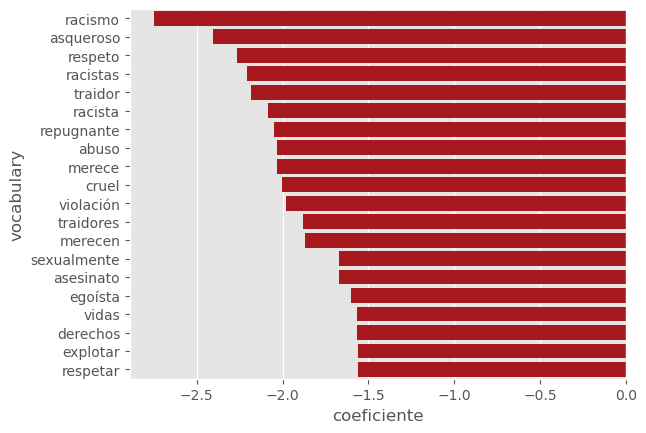

In [109]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('ggplot')

sns.barplot(data = voc_df.head(20),
            x = 'coeficiente',
            y = 'vocabulary',
            color = '#c00009',
            orient='h')

<Axes: xlabel='coeficiente', ylabel='vocabulary'>

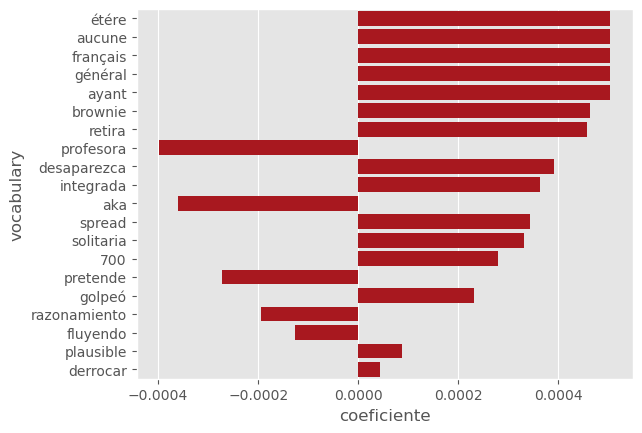

In [110]:
sns.barplot(data = voc_df.tail(20),
            x = 'coeficiente',
            y = 'vocabulary',
            color = '#c00009',
            orient='h')

In [120]:
voc_df.reset_index(inplace=True)

In [133]:
voc_df.shape

(23716, 4)

In [122]:
voc_df[voc_df.vocabulary == 'trump']

,index,vocabulary,coeficiente,importance
11106,22382,trump,0.103155,0.103155


In [125]:
voc_df[voc_df.vocabulary == 'macron']

,index,vocabulary,coeficiente,importance
1828,14103,macron,0.4315,0.4315


In [126]:
voc_df[voc_df.vocabulary == 'casa']

,index,vocabulary,coeficiente,importance
1627,3935,casa,0.454888,0.454888


In [130]:
voc_df[voc_df.vocabulary == 'blanca']

,index,vocabulary,coeficiente,importance
9756,3203,blanca,-0.124799,0.124799
